# An Evaluation of the Need for Additional Urgent Care/Emergency Rooms
> Clay M. Steward, in partial completion of the IBM Applied Data Science Capstone project on Coursera

## Introduction
A growing concern for most cities and communities is the need for additional medical treatment facilities or service.  Continued increases in population, ages, and widening financial gaps are putting increasing pressure on fire department or other emergency medical service (EMS) provider agencies to fill this needed service.  While most service agencies evaluate items such as call volume and response component times, they rarely feel impowered to evaluate other aspects that effect their workload.  One potential issue is the availability of definitive care facilities such as doctors’ offices, clinics, hospitals, emergency, and urgent care centers.

The evaluation being completed here is an introductory evaluation of locations of facilities versus the locations of the medical incidents that an EMS provider responds.  The underlying themes here are that workload for the EMS provider is increased as the distance to the medical facility increases, due to extended transport times, and location of medical facilities may have an impact on whether patients utilize these facilities directly or look for assistance from emergency service providers.

Many strategic planning executives, senior officers, and community leaders may be interested in this type of evaluation.  This type of evaluation may help city or county leadership, such as fire or ambulance services leadership, or care facility owners make better decisions on the location and types of services provided.  The point here is that there are more dimensions to most service analytics and there are tools available to help communities and agencies evolve.

How to deliver emergency and urgent medical care is a very important evaluation that should include multiple facets.  While this paper is meant to introduce this type of evaluation to the interested service provider or leader, it must be made clear that there are too many variables at issue for this paper to be a definitive application of the processes herein.  This evaluation is an academic evaluation and many of the factors related to the actual selection of urgent/emergent care providers were not readily available and so were not evaluated.  Items such as available real estate, financial impact, zoning, political and social will, available staffing talent, among others are not approached or discussed.  Therefore, this paper should be viewed as an introduction into using computer modeling, mathematical processes, and machine learning to begin to identify areas of weakness, not as a recommendation for action.

## Python Libraries Used in this Evaluation
The format used in this evaluation and the requirement for the course, by necessity, requires a great deal of computer code to be visible to the reader.  This might prove slightly non-sequitur to a reader who is not familiar with the python computer language so every effort will be used to clean the code and show what is needed for accuracy.  Code will be grouped together as much as possible, and the non-technical reader should feel free to skip over these segments.  

#### The following data libraries are used in the Python code for data evaluation.

In [1]:
# Importing the libraries needed for the evaluation of the dataframes and geojason files and setting parameters.

import numpy as np
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import requests
import pandas as pd
from pandas.io.json import json_normalize
import geopandas as gpd
from shapely.geometry import Point
import folium as fl
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot
import os
import folium
import datetime
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

%matplotlib inline  

# Display Options
pd.options.display.max_rows = None
pd.options.display.max_columns = None

## Data 
The data for this evaluation is found in three separate sets.  The first set is a five-year history of emergency medical incidents that the San Francisco Fire Department responded to.  The second set is a list of urgent care and emergency room facilities from the Four Square API data set that includes urgent care and emergency rooms.  The final set is the GeoJSON file that includes all the San Francisco analysis districts.  The incident data has analysis districts already associated with it so the Four Square data will be joined using GeoPandas methodology with the analysis district data.  This should increase the ability to analyze the data utilizing the analysis districts.

### San Francisco Incident Data
San Francisco maintains a publicly accessible fire department incident data set at https://datasf.org/opendata/.  This data included all apparatus that responded and all incidents.  The information was filtered to include only medical incidents where the apparatus arrived. Cancelled incidents, not found incidents and other similar incidents were excluded from the data set.  In addition the apparatus were combined so each incident has only one record and only apparatus that would be typically considered an effective unit, including ambulances and fire apparatus.  The final data set includes the following data points for each incident:

|Field Name             |Data Type     |Notes                                                                |
|:----------------------|:-------------|:--------------------------------------------------------------------|
|Incident Number        |String        |Key number for the incident, unique for each incident.               |
|Call Type              |String        |The call type, all calls are listed as Medical Incident.             |
|Call Final Disposition |String        |The final disposition of the call.                                   |
|Latitude               |Float         |Latitude of the incident.                                            |
|Longitude              |Float         |Longitude of the incident.                                           |
|Neighborhoods          |String        |Standard neighborhood name, defined by the city.                     |
|Call Date              |Date/Time     |M/D/YYYY format for the incident start.                              |
|Recieved_DTTM          |Date/Time     |M/D/YYYY hh:mm:ss for the time the incident was recieved by dispatch.|
|Original Priority      |String        |The original priority of the incident 1-3.                           |
|Priority               |String        |The priority of the dispatch of the incident 1-3.                    |
|Final Priority         |String        |The final priority of the incident 1-3.                              |
|Entry_DTTM             |Date/Time     |M/D/YYYY hh:mm:ss the incident was originally entered by dispatch.   |
|FirstUnit_Dispatch_DTTM|Date/Time     |M/D/YYYY hh:mm:ss the first effective unit was dispatched.           |
|FirstUnit_Resonse_DTTM |Date/Time     |M/D/YYYY hh:mm:ss the first effective unit responded.                |
|FirstUnit_OnScene_DTTM |Date/Time     |M/D/YYYY hh:mm:ss the first effective unit arrived on scene.         |
|First_ALSOnScene       |Date/Time     |M/D/YYYY hh:mm:ss the first ALS unit arrived on scene.               |
|Transport_DTTM         |Date/Time     |M/D/YYYY hh:mm:ss the patient started transport.                     |
|Hospital_DTTM          |Date/Time     |M/D/YYYY hh:mm:ss the patient arrived at the hospital.               |
|LastUnit_Available_DTTM|Date/Time     |M/D/YYYY hh:mm:ss the last unit cleared the incident.                |

In [2]:
#  This data is found on the local drive.
incidents = 'C:/Users/suenc/OneDrive/Training/CourseraDataScience/Capstone/5YrMedical.xlsx'

# Reading the data in and evaluation:
df_incidents = pd.read_excel(incidents)
print(df_incidents.info())
df_incidents.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471962 entries, 0 to 471961
Data columns (total 20 columns):
Incident Number                         471962 non-null int64
Call Type                               471962 non-null object
Call Final Disposition                  471962 non-null object
Latitude                                471962 non-null float64
Longitude                               471962 non-null float64
Neighborhooods - Analysis Boundaries    471962 non-null object
Call_Date                               471962 non-null datetime64[ns]
Received_DTTM                           471962 non-null datetime64[ns]
Original Priority                       471940 non-null object
Priority                                471962 non-null object
Final Priority                          471962 non-null int64
Entry_DTTM                              471962 non-null datetime64[ns]
FirstUnit_Distpatch_DTTM                471962 non-null datetime64[ns]
FirstUnit_Response_DTTM               

Incident Number         Call Type Call Final Disposition   Latitude  \
0         16000001  Medical Incident       Code 2 Transport  37.776688   
1         16000002  Medical Incident                  Other  37.794479   
2         16000005  Medical Incident       Code 2 Transport  37.783932   
3         16000006  Medical Incident       Code 2 Transport  37.778538   
4         16000007  Medical Incident       Code 2 Transport  37.744759   

    Longitude Neighborhooods - Analysis Boundaries  Call_Date  \
0 -122.426376                         Hayes Valley 2016-01-01   
1 -122.394745       Financial District/South Beach 2016-01-01   
2 -122.412598                           Tenderloin 2016-01-01   
3 -122.417397                           Tenderloin 2016-01-01   
4 -122.422440                       Bernal Heights 2016-01-01   

            Received_DTTM Original Priority Priority  Final Priority  \
0 2016-01-01 00:00:43.027                 2        2               2   
1 2016-01-01 00:03:46.973                 2        2               2   
2 2016-01-01 00:07:05.002                 3        3               3   
3 2016-01-01 00:05:48.019                 3        E               3   
4 2016-01-01 00:08:51.965                 3        3               3   

               Entry_DTTM FirstUnit_Distpatch_DTTM FirstUnit_Response_DTTM  \
0 2016-01-01 00:02:42.000  2016-01-01 00:03:25.978 2016-01-01 00:05:22.013   
1 2016-01-01 00:03:46.973  2016-01-01 00:05:29.011                     NaT   
2 2016-01-01 00:08:35.030  2016-01-01 00:08:51.014 2016-01-01 00:09:01.037   
3 2016-01-01 00:08:40.042  2016-01-01 00:09:31.968 2016-01-01 00:10:21.994   
4 2016-01-01 00:10:27.005  2016-01-01 00:10:39.014 2016-01-01 00:11:31.027   

   FirstUnit_OnScene_DTTM        First_ALSOnScene          Transport_DTTM  \
0 2016-01-01 00:18:50.026                     NaT 2016-01-01 00:42:14.026   
1                     NaT                     NaT                     NaT   
2 2016-01-01 00:12:01.958 2016-01-01 00:12:01.958 2016-01-01 00:22:28.013   
3 2016-01-01 00:12:58.032 2016-01-01 00:12:58.032 2016-01-01 00:31:14.016   
4 2016-01-01 00:13:19.027 2016-01-01 00:13:19.027 2016-01-01 00:29:59.971   

            Hospital_DTTM LastUnit_Available_DTTM  IncidentCounts  
0 2016-01-01 00:55:21.994 2016-01-01 01:17:46.982            True  
1                     NaT 2016-01-01 00:07:32.995            True  
2 2016-01-01 00:36:03.024 2016-01-01 01:11:37.018            True  
3 2016-01-01 00:38:31.978 2016-01-01 01:22:30.029            True  
4 2016-01-01 00:51:33.984 2016-01-01 01:17:18.038            True

### Four Square Data
The Four Square data set will be the venue data in Foursquare.  This will be found by utilizing an API query to https://api.foursquare.com/v2/venues/.  By utilizing the Foursquare URI with a version data of 20201231 the incidents, incident types, dates and times will be evaluated for each neighborhood against the category and types of venues in the area.  Therefore, the primary venue data set from Foursquare will include:
* Index (int)
* ID (string)
* Name (string)
* Category (string)
+ Latitude (float)
- Longitude (float)

This data will be gathered for the following categories with the assumption that these two facilities would be the interim transportation or treatment center destination for the EMS or for a walk-in patient.  It is important to note that this is an assumption and may not be valid for the San Francisco Fire Department, as some agencies nationwide are not allowed to transport to urgent care facilities.  The Four Square categories are:
* Emergency Room (4bf58dd8d48988d194941735)
* Urgent Care Facility (56aa371be4b08b9a8d573526)

It was found that the Four Square API did not allow large volumes of data, such as all restaurants or stores, to be accessed in a single load.  After much evaluation it was discovered that the limit was between 90 and 120 entries for each request.  However, a direct and indirect evaluation finds that each of these two categories have less than 50 associated entries each, so there is high confidence that all data available on the Four Square data set was included.  To ensure this is the case each data set is downloaded independently and then the data combined.

In [3]:
#  Gathering the Four Square Data

#  Setting the access variables.  Hidden for security reasons using the OS.Enviorn library
CLIENT_ID = os.environ.get('4squareclient')
CLIENT_SECRET = os.environ.get('4squaresecret')
ACCESS_TOKEN = os.environ.get('4squaretoken')
VERSION = '20201231'

city ='SAN FRANCISCO, CA'
er_cat = '4bf58dd8d48988d194941735'
uc_cat = '56aa371be4b08b9a8d573526'
limit = 50

url_er = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&categoryId={}&near={}&oauth_token={}&v={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, er_cat, city, ACCESS_TOKEN, VERSION, limit)
url_uc = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&categoryId={}&near={}&oauth_token={}&v={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, uc_cat, city, ACCESS_TOKEN, VERSION, limit)

In [4]:
#  This code gets the data (testing limited to 30 results) and normalize it into a dataframe
initialdata_er = requests.get(url_er).json()
initialdata_uc = requests.get(url_uc).json()

#  Assigning relevant part of JSON to venues
service_er = initialdata_er['response']['venues']
service_uc = initialdata_uc['response']['venues']

#  Making the venues dataframe for analysis
er_service_df = json_normalize(service_er)
uc_service_df = json_normalize(service_uc)

print("ER LOCATIONS INFORMATION: ", er_service_df.info())
print("UC LOCATIONS INFORMATION: " ,uc_service_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 18 columns):
id                           46 non-null object
name                         46 non-null object
categories                   46 non-null object
referralId                   46 non-null object
hasPerk                      46 non-null bool
location.lat                 46 non-null float64
location.lng                 46 non-null float64
location.labeledLatLngs      46 non-null object
location.cc                  46 non-null object
location.state               46 non-null object
location.country             46 non-null object
location.formattedAddress    46 non-null object
location.address             33 non-null object
location.postalCode          39 non-null object
location.city                44 non-null object
location.crossStreet         17 non-null object
venuePage.id                 3 non-null object
location.neighborhood        1 non-null object
dtypes: bool(1), float64(2), object

#### Preparing the Four Square Data
The data included into these two sets is to undergo several steps to shape it for ease of use.  First the two data sets are combined into one.  Then this new data set is shaped so the headings and subsequent data are clearer and more easily read.  Finally, only four columns will be required, so the unused data will be dropped.

In [5]:
#  Combining the dataframes into one data frame
service_df = pd.concat([er_service_df, uc_service_df], ignore_index = True, sort = True)

# Shaping the data for clarity and removing the redundant "location." headings
filtered_columns = ['name', 'categories'] + [col for col in service_df.columns if col.startswith('location.')] + ['id']
service_df_filter = service_df.loc[:, filtered_columns]

# This function rips only the category information from the JSON data currently in the venues.categories column
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# This employes the above function to the dataframe.
service_df_filter['categories'] = service_df_filter.apply(get_category_type, axis=1)

# This removes some of the unneeded column punctuation that comes over with a JSON data type.
service_df_filter.columns = [column.split('.')[-1] for column in service_df_filter.columns]

print(service_df_filter.info())

#  Finally removing the data points and finalizing the working dataframe.
df_services = service_df_filter[['id','name','categories', 'lat','lng']]

print(df_services.head(2))
print(df_services.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 15 columns):
name                82 non-null object
categories          82 non-null object
address             63 non-null object
cc                  82 non-null object
city                78 non-null object
country             82 non-null object
crossStreet         32 non-null object
formattedAddress    82 non-null object
labeledLatLngs      82 non-null object
lat                 82 non-null float64
lng                 82 non-null float64
neighborhood        2 non-null object
postalCode          71 non-null object
state               82 non-null object
id                  82 non-null object
dtypes: float64(2), object(13)
memory usage: 9.7+ KB
None
                         id                                  name  \
0  4d5f3f25149637047632d594      Kaiser Permanente Emergency Room   
1  4dfce32be4cdbe059c3a9905  Firecrotch Rescue Center: SF Chapter   

       categories        lat         lng  
0 

### Analysis Districts
The city government of San Francisco has broken their city into analysis neighborhoods.  According to their website at https://data.sfgov.org these districts are determined by capturing areas as defined by census blocks.  This will be an assist later analytics and keeps the data in buckets that the city already utilizes.  This is a series of GeoJSON geographic shapes with the associated neighborhood names.  The incident data already includes this information, but the Four Square data does not.  As a departure from some of the loading of the data, this will be uploaded using the geopandas library for ease of joining the Four Square data.

In [6]:
# Setting the local file name for ease of use in the download.
geography = 'C:/Users/suenc/OneDrive/Training/CourseraDataScience/Capstone/Analysis Neighborhoods.geojson'

# Reading in the file utilizing geo-pandas.
analysis_dist = gpd.read_file(geography)
analysis_dist.head(2)

nhood                                           geometry
0  Bayview Hunters Point  MULTIPOLYGON (((-122.38158 37.75307, -122.3815...
1         Bernal Heights  MULTIPOLYGON (((-122.40361 37.74934, -122.4037...

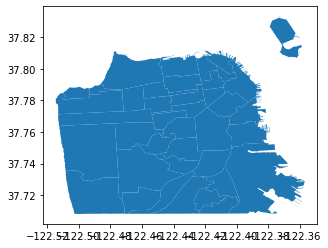

In [7]:
# This is a quick overview of what the analysis districts look like.
analysis_dist.plot()

## Data Evaluation Methodology
With the data identified and loaded the analysis process followed a question/answer process flow.  As information would present itself it was shaped and evaluated.  While this is a useful tool for data exploration and eventually addressing a given thesis, it is not very organized and difficult for the reader to follow.  To make this evaluation less ambiguous the primary operations of the data will be grouped together.  The two primary sections are:

* Data joining, shaping, and erroneous data removal,
* Visualizations, statistical evaluations, and machine learning codes.

### Data Joining, Shaping and Erroneous Data Removal
This section organizes and presents the methods used to make the data in the data sets ready for the analysis that will follow.

#### Combined Analysis Districts and Four Square Service Locations
The districts in and of themselves do not provide much to the understanding of this analysis, however it does provide useful buckets when performing some performance data.  In addition, since the city of San Francisco already utilizes this system, it may be useful for their management. 

Adding analysis district information to the Four Square data will expand its usability.  The next series of code is to build a new geodata set utilizing the Four Square data and combine it with the analysis districts.  There are two distinct steps to this, first create a new geopandas dataframe on the services dataframe, the second is to utilize the geopandas join feature to merge the two data sets.

##### The first step:  Combine service locations and analysis districts utilizing geopandas.

The incidents data is now moved into a geopanda's data frame. To make sure mapping goes smooth and the analysis districts line up the coordinates will be in the same coordinate system as the analysis districts.

    Check CRS (coordinate type) for the analysis district geodataframe,
    Create points that will act as geometry for the data set,
    Create a geodataframe using the points,
    Define the geodataframe with the correct CRS.

This will be done for both incidents and open data dataframes.

In [8]:
# Checking the coordinate system of the analysis districts.
analysis_dist.crs

{'init': 'epsg:4326'}

In [9]:
#  The new geodata frame MUST use epsg:4326
#  Creating the point for the new dataframe - using the point function from the Shapely library
points = df_services.apply(lambda row: Point(row.lng, row.lat), axis = 1)

#  Creating a geodata frame
gdf_services = gpd.GeoDataFrame(df_services, geometry = points)

#  Ensureing the dataframe follows the correct CRS
gdf_services.crs = {'init': 'epsg:4326'}

gdf_services.head(2)

id                                  name  \
0  4d5f3f25149637047632d594      Kaiser Permanente Emergency Room   
1  4dfce32be4cdbe059c3a9905  Firecrotch Rescue Center: SF Chapter   

       categories        lat         lng                     geometry  
0  Emergency Room  37.782051 -122.442577  POINT (-122.44258 37.78205)  
1  Emergency Room  37.774396 -122.422790  POINT (-122.42279 37.77440)

##### Second Step:  Combining the two data sets.

Now that the services data frame is converted to a geodataframe utilizing geopandas, it is a simple join feature within geopandas.  In this case the services dataframe is the primary data frame and data will be kept, and the new information will be added using an inner join and a within feature.

In [10]:
gdf_finalservices = gpd.sjoin(gdf_services, analysis_dist, how="inner", op='within')
print(gdf_finalservices.info())
gdf_finalservices.head(2)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 38 entries, 0 to 79
Data columns (total 8 columns):
id             38 non-null object
name           38 non-null object
categories     38 non-null object
lat            38 non-null float64
lng            38 non-null float64
geometry       38 non-null geometry
index_right    38 non-null int64
nhood          38 non-null object
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 2.7+ KB
None


id                                     name  \
0   4d5f3f25149637047632d594         Kaiser Permanente Emergency Room   
19  4dc5dd6a7d8b14fb463684b7  St Marys Medical Center- Emergency Room   

        categories        lat         lng                     geometry  \
0   Emergency Room  37.782051 -122.442577  POINT (-122.44258 37.78205)   
19  Emergency Room  37.774058 -122.453782  POINT (-122.45378 37.77406)   

    index_right              nhood  
0            17  Lone Mountain/USF  
19           17  Lone Mountain/USF

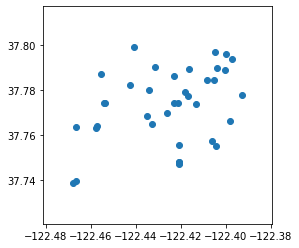

In [11]:
#  This provides a general overview of where these facilities are located in relation to the city.

gdf_finalservices.plot()

##### Unforeseen Benefit of the Merging by Geography
After joining the data there was a change in the total facilities from 82 to 40 facilities.  After evaluation it was noted that several of the points were not actually within the city boundaries, and by happy coincidence a few of the dropped facilities were not of the category they were coded in.  While a full survey of the facilities close should include neighboring towns and locations, for this evaluation it is more effective to only include facilities within the actual city boundaries.

### Data Shaping
This section includes the removal of data that was not used, as well as renaming specific columns for ease of use.

#### Incident Data
The incident data set is very robust and complete.  It was identified that there two parameters would be useful and they were added.  These are the the year of the incident, and the time it took to transport the patient.  After multiple evaluations it became apparent that much of the included data would not be used in the final evaluation, so many columns in the data frame were removed for improved performance.  

It also became necessary to break the incident information into 4 sets of data.
    * Analysis Districts (including GeoJSON file),
    * Full incident data set,
    * Code 3 incident data set,
    * Code 2 incident data set,
    * Other disposition data set,
    * Grouped counts by neighborhood,
    * Grouped counts by year.

In [12]:
#  Additional fields - year and transport time.
df_incidents['Year'] = pd.DatetimeIndex(df_incidents['Call_Date']).year
df_incidents['Transport Time'] = (df_incidents['Hospital_DTTM'] - df_incidents['Transport_DTTM'])//pd.Timedelta('1s')

In [13]:
#  Removal of Specific Columns Not Used in the Analysis.
#  It was determined that dropping the data, rather than creating a new dataframe, improved memory performance.
df_incidents.drop(['Call Type', 'Original Priority', 'Priority', 'Final Priority', 'Entry_DTTM',
                  'IncidentCounts', 'Received_DTTM', 'FirstUnit_Distpatch_DTTM', 'FirstUnit_Response_DTTM',
                  'FirstUnit_OnScene_DTTM', 'First_ALSOnScene', 'LastUnit_Available_DTTM' ],
                  axis = 1, inplace = True)

# The names of the columns were cumbersome and some adjustments were made for clarity/
df_incidents.rename(columns={'Incident Number':'ID', 'Neighborhooods - Analysis Boundaries':'Neighborhood', 
                             'Call_Date': 'Date', 'Transport_DTTM': 'Transporting', 'Hospital_DTTM': 'At Hospital',
                            'Call Final Disposition': 'Disposition'}, inplace = True)

In [14]:
#  Fixing Latitude/Longitude Error That Translates Throughout The Data Sets
print("Pre correction universal values: ", df_incidents.shape)
df_incidents = df_incidents[(df_incidents['Latitude'] >= 35) & (df_incidents['Longitude']<= -120)]
print("Post correction universal values: ", df_incidents.shape)

# To evaluate based on years
df_yearcount = df_incidents[['ID', 'Year']]
df_yearcount = df_yearcount.groupby(by = 'Year', as_index = False).agg('count')
df_yearcount.sort_values(['ID'], ascending = False, axis = 0, inplace = True)
df_yearcount.rename(columns={'ID': 'Total'}, inplace = True)
print(df_yearcount.head())


Pre correction universal values:  (471962, 10)
Post correction universal values:  (444158, 10)
   Year  Total
3  2019  98976
2  2018  98389
1  2017  96257
0  2016  91308
4  2020  59228


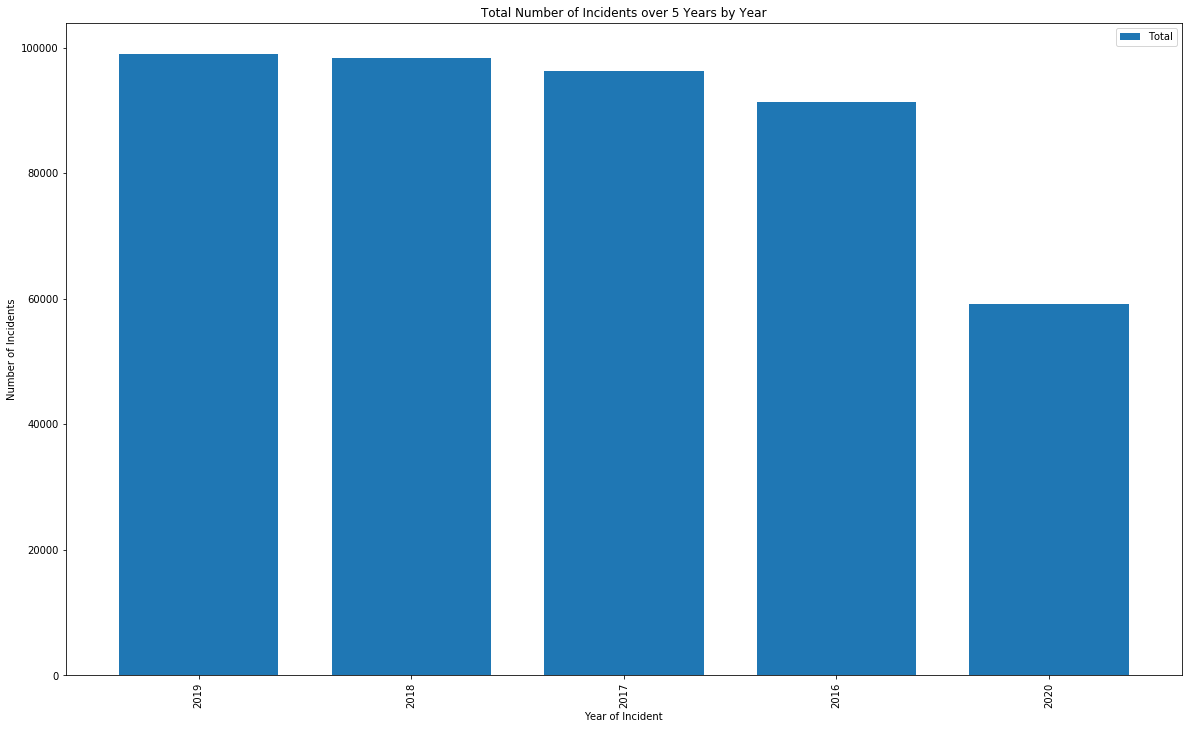

In [15]:
# A quick plot to see which years would be the most appropriate
# Year over year trend bar chart
df_yearcount.plot.bar(x = 'Year', y = 'Total', width = .75, figsize = (20, 12))

plt.xlabel("Year of Incident")
plt.ylabel("Number of Incidents")
plt.title("Total Number of Incidents over 5 Years by Year")

plt.show()

In [16]:
df_incidents.describe()

ID       Latitude      Longitude           Year  \
count  4.441580e+05  444158.000000  444158.000000  444158.000000   
mean   1.793439e+07      37.768821    -122.424315    2017.861669   
std    1.328914e+06       0.023836       0.026297       1.332713   
min    1.600000e+07      37.680099    -122.513649    2016.000000   
25%    1.703169e+07      37.755898    -122.433800    2017.000000   
50%    1.805353e+07      37.777626    -122.417046    2018.000000   
75%    1.907490e+07      37.784561    -122.408508    2019.000000   
max    2.010121e+07      37.831665    -122.332573    2020.000000   

       Transport Time  
count    3.791530e+05  
mean     1.283280e+03  
std      1.740409e+05  
min     -2.678200e+06  
25%      5.220000e+02  
50%      8.420000e+02  
75%      1.254000e+03  
max      2.894572e+07

While performing much of the later data evaluation it was determined that the clusters were too dense to adequately see any usable clusters.  Therefore it was decided to limit the number of years of data to be evaluated.  As the preceding bar chart shows, the top two years were 2018 and 2019.  It is also evident that 2020 was significaly lower, and there is industry evidence to show that the Covid-19 pandemic slowed the use of emergency services significanly and should be understood as an anomolis year.  Therefore, even though 2020 is the most recent data, it seemed prudent to discard that year's data in favor of the top two years prior, 2018 and 2019.

In [17]:
# Creating the analytical set
# Reducing the data set to the two most useful years of data, 2018 and 2019
df_incidents = df_incidents[(df_incidents['Year'] >= 2018) & (df_incidents['Year'] <= 2019)]

#  Creating the three transport disposition data sets
df_code3 = df_incidents[df_incidents['Disposition'] == 'Code 3 Transport']
df_code2 = df_incidents[df_incidents['Disposition'] == 'Code 2 Transport']
df_other = df_incidents[(df_incidents['Disposition'] != 'Code 2 Transport') & 
                        (df_incidents['Disposition'] != 'Code 3 Transport')]

print("Code 3: ", df_code3.info())
print("Code 2: ", df_code2.info())
print("Other:  ", df_other.info())

# Creating the count by neighborhood data set and the count by years data sets
# To evaluate based on neighborhoods
df_nborcount = df_incidents[['ID', 'Neighborhood']]
df_nborcount = df_nborcount.groupby(by = 'Neighborhood', as_index = False).agg('count')
df_nborcount.sort_values(['ID'], ascending = False, axis = 0, inplace = True)
df_nborcount.rename(columns={'ID': 'Total'}, inplace = True)
print(df_nborcount.head())

# To evaluate based on years and call disposition
df_disposition = df_incidents[['ID', 'Year', 'Disposition']]
df_disposition = df_disposition.groupby(['Year','Disposition']).agg('count')
df_disposition.rename(columns={'ID': 'Total'}, inplace = True)
print(df_disposition.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10783 entries, 187575 to 384922
Data columns (total 10 columns):
ID                10783 non-null int64
Disposition       10783 non-null object
Latitude          10783 non-null float64
Longitude         10783 non-null float64
Neighborhood      10783 non-null object
Date              10783 non-null datetime64[ns]
Transporting      10741 non-null datetime64[ns]
At Hospital       10624 non-null datetime64[ns]
Year              10783 non-null int64
Transport Time    10624 non-null float64
dtypes: datetime64[ns](3), float64(3), int64(2), object(2)
memory usage: 926.7+ KB
Code 3:  None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 158920 entries, 187565 to 384929
Data columns (total 10 columns):
ID                158920 non-null int64
Disposition       158920 non-null object
Latitude          158920 non-null float64
Longitude         158920 non-null float64
Neighborhood      158920 non-null object
Date              158920 non-null datetim

In [18]:
df_incidents.describe()

ID       Latitude      Longitude           Year  \
count  1.973650e+05  197365.000000  197365.000000  197365.000000   
mean   1.857918e+07      37.769088    -122.424040    2018.501487   
std    5.032834e+05       0.023713       0.026115       0.499999   
min    1.800000e+07      37.680099    -122.513649    2018.000000   
25%    1.807649e+07      37.756508    -122.433083    2018.000000   
50%    1.900046e+07      37.777714    -122.416901    2019.000000   
75%    1.907885e+07      37.784748    -122.408485    2019.000000   
max    1.915824e+07      37.831665    -122.361473    2019.000000   

       Transport Time  
count    1.686890e+05  
mean     9.722106e+02  
std      1.463989e+05  
min     -2.678200e+06  
25%      5.240000e+02  
50%      8.440000e+02  
75%      1.252000e+03  
max      2.885909e+07

In [19]:
df_code3.describe()

ID      Latitude     Longitude          Year  Transport Time
count  1.078300e+04  10783.000000  10783.000000  10783.000000    10624.000000
mean   1.856885e+07     37.764391   -122.429639   2018.491329      588.997364
std    5.029640e+05      0.026297      0.029372      0.499948     1200.754708
min    1.800002e+07     37.707962   -122.513649   2018.000000  -114092.000000
25%    1.807512e+07     37.742989   -122.446705   2018.000000      323.000000
50%    1.815128e+07     37.773834   -122.420418   2018.000000      504.000000
75%    1.907422e+07     37.784286   -122.409519   2019.000000      761.000000
max    1.915823e+07     37.831665   -122.361473   2019.000000     5339.000000

In [20]:
df_code2.describe()

ID       Latitude      Longitude           Year  \
count  1.589200e+05  158920.000000  158920.000000  158920.000000   
mean   1.857730e+07      37.769525    -122.423662    2018.499931   
std    5.032599e+05       0.023407       0.025800       0.500002   
min    1.800000e+07      37.680099    -122.513649    2018.000000   
25%    1.807596e+07      37.757701    -122.432259    2018.000000   
50%    1.815338e+07      37.777924    -122.416634    2018.000000   
75%    1.907822e+07      37.784767    -122.408485    2019.000000   
max    1.915824e+07      37.831665    -122.363083    2019.000000   

       Transport Time  
count    1.574000e+05  
mean     9.991046e+02  
std      1.515577e+05  
min     -2.678200e+06  
25%      5.490000e+02  
50%      8.700000e+02  
75%      1.276000e+03  
max      2.885909e+07

In [21]:
df_other.describe()

ID      Latitude     Longitude          Year  Transport Time
count  2.766200e+04  27662.000000  27662.000000  27662.000000      665.000000
mean   1.859402e+07     37.768406   -122.424031   2018.514388      728.803008
std    5.032812e+05      0.024177      0.026317      0.499802      592.805990
min    1.800002e+07     37.708084   -122.513649   2018.000000    -1900.000000
25%    1.808054e+07     37.754117   -122.433588   2018.000000      299.000000
50%    1.900556e+07     37.777084   -122.417084   2019.000000      627.000000
75%    1.908387e+07     37.784809   -122.408028   2019.000000     1074.000000
max    1.915824e+07     37.831665   -122.361473   2019.000000     3355.000000

#### Location Data
Most of the errors in the location data was repaired in the merging of the analysis districts however there was still a need to reduce the information in the data for clarity and break the data into two sets.  Since it is assumed that priority incidents are transported to a higher level of care, in this case an emergency room or hospital, the locations were seperated by the higher and lower priority facilities.

In [22]:
#  Minimizing the dataframe for ease of evaluation
df_serviceloc = gdf_finalservices[['categories', 'lat', 'lng', 'nhood']]

# Creating the higher priority (ER) and lower prioirty (UC - urgent care) facility data sets.
df_er = df_serviceloc[(df_serviceloc['categories'] == 'Emergency Room') | (df_serviceloc['categories'] == 'Hospital')]
df_uc = df_serviceloc[(df_serviceloc['categories'] != 'Emergency Room') & (df_serviceloc['categories'] != 'Hospital')]

print("All Data: ", df_serviceloc.info())
print("Priority Facilities: ", df_er.info())
print("Urgent Care Facilities: ", df_uc.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 79
Data columns (total 4 columns):
categories    38 non-null object
lat           38 non-null float64
lng           38 non-null float64
nhood         38 non-null object
dtypes: float64(2), object(2)
memory usage: 1.5+ KB
All Data:  None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 0 to 40
Data columns (total 4 columns):
categories    17 non-null object
lat           17 non-null float64
lng           17 non-null float64
nhood         17 non-null object
dtypes: float64(2), object(2)
memory usage: 680.0+ bytes
Priority Facilities:  None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 46 to 79
Data columns (total 4 columns):
categories    21 non-null object
lat           21 non-null float64
lng           21 non-null float64
nhood         21 non-null object
dtypes: float64(2), object(2)
memory usage: 840.0+ bytes
Urgent Care Facilities:  None


#### Erronious Data Removal
In the methodology section and associated evaluations, several additional steps were taken to view the data as either a graph, chart, map or to perform the statistical analysis.  While most of these fixes were identified as the methodology progressed and often these code sets are near where the issues were found, for clarity sake and document flow these steps will be added here instead.  

A universal error that needed to be corrected was missing or incorrect geography information.  When evaluating transport time it became evident that there was missing and erronious data here as well.  Negative transport times, a good trick if you can really accomplish it, and transport times in the multiple hours were all recorded.  A drive time evaluation utilizing a common direction/drive time application from several points to several points in the city indicated that most point to point drive times were less than 30 minutes.  Therefore drive times greater than one hour (3600 seconds) were removed during the analysis.  While it is certainly feasible that a transport could take longer than one hour, these outliers do not add to the the information, rather they detract from the majority.

In [23]:
# When looking at the transpoort times it became apparent that some of the data was missing or incorrect.
print("Pre correction code 3 and code 2 transport time shape: ", df_code3.shape, df_code2.shape)
df_code3_trans = df_code3[(df_code3['Transport Time']> 0) & (df_code3['Transport Time'] < 3601)]
df_code2_trans = df_code2[(df_code2['Transport Time']> 0) & (df_code2['Transport Time'] < 3601)]
print("Post correction code 3 and code 2 transport time shape: ", df_code3_trans.shape, df_code2_trans.shape)

Pre correction code 3 and code 2 transport time shape:  (10783, 10) (158920, 10)
Post correction code 3 and code 2 transport time shape:  (10492, 10) (155985, 10)


#### Mapping Code
Because the code to build maps can be fairly long, prior to evaluating the maps the code is moved here.  The intent is to clean up the analysis portion of the report.

In [24]:
#  FIRST MAP - CALL DENSITY BY NEIGHBORHOOD

threshold_scale = np.linspace(df_nborcount['Total'].min(),
                              df_nborcount['Total'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() 
threshold_scale[-1] = threshold_scale[-1] + 1

# San Francisco latitude and longitude values
latitude = 37.77
longitude = -122.42

# create map and display it
sanfran_map_density = folium.Map(location=[latitude, longitude], zoom_start=12)

sanfran_map_density.choropleth(
    geo_data=geography,
    data=df_nborcount,
    columns=['Neighborhood', 'Total'],
    key_on='feature.properties.nhood',
    fill_color = 'YlOrRd',
    threshold_scale = threshold_scale,
    fill_opacity = 0.5,
    line_opacity = 0.7,
    legend_name='Incident Volume by Neighborhood'
)

# Adding Locations 

for lat, lng, in zip(gdf_finalservices.lat, gdf_finalservices.lng):
    sanfran_map_density.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius = 2,
            color = 'blue',
            fill = True,
            fill_color = 'blue',
            fill_opacity = 0.5
        )
    )


In [25]:
#  SECOND MAP - AVERAGE TRANSPORT TIME BY NEIGHBORHOOD PRIORITY TRANSPORT

df_code3_trans = df_code3_trans.groupby(['Neighborhood'], as_index = False).mean()

threshold_scale_time = np.linspace(df_code3_trans['Transport Time'].min(),
                              df_code3_trans['Transport Time'].max(),
                              6, dtype=int)
threshold_scale_time = threshold_scale_time.tolist() 
threshold_scale_time[-1] = threshold_scale_time[-1] + 1

# San Francisco latitude and longitude values
latitude = 37.77
longitude = -122.42

# create map and display it
sanfran_map_time = folium.Map(location=[latitude, longitude], zoom_start=12)

sanfran_map_time.choropleth(
    geo_data=geography,
    data=df_code3_trans,
    columns=['Neighborhood', 'Transport Time'],
    key_on='feature.properties.nhood',
    fill_color = 'YlOrRd',
    threshold_scale = threshold_scale_time,
    fill_opacity = 0.5,
    line_opacity = 0.8,
    legend_name='Average Priority Transport Time by Neighborhood'
)

# Adding Locations 

for lat, lng, in zip(df_er.lat, df_er.lng):
    sanfran_map_time.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius = 2,
            color = 'blue',
            fill = True,
            fill_color = 'blue',
            fill_opacity = 0.5
        )
    )


In [26]:
#  THIRD MAP- AVERAGE TRANSPORT TIME BY NEIGHBORHOOD NON-PRIORITY TRANSPORT

df_code2_trans = df_code2_trans.groupby(['Neighborhood'], as_index = False).mean()

threshold_scale_time = np.linspace(df_code2_trans['Transport Time'].min(),
                              df_code2_trans['Transport Time'].max(),
                              6, dtype=int)
threshold_scale_time = threshold_scale_time.tolist() 
threshold_scale_time[-1] = threshold_scale_time[-1] + 1

# San Francisco latitude and longitude values
latitude = 37.77
longitude = -122.42

# create map and display it
sanfran_map_time2 = folium.Map(location=[latitude, longitude], zoom_start=12)

sanfran_map_time2.choropleth(
    geo_data=geography,
    data=df_code2_trans,
    columns=['Neighborhood', 'Transport Time'],
    key_on='feature.properties.nhood',
    fill_color = 'YlOrRd',
    threshold_scale = threshold_scale_time,
    fill_opacity = 0.5,
    line_opacity = 0.8,
    legend_name='Average Non-Priority Transport Time by Neighborhood'
)

# Adding Locations 

for lat, lng, in zip(df_er.lat, df_er.lng):
    sanfran_map_time2.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius = 2,
            color = 'red',
            fill = True,
            fill_color = 'red',
            fill_opacity = 0.5
        )
    )

for lat, lng, in zip(df_uc.lat, df_uc.lng):
    sanfran_map_time2.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius = 2,
            color = 'blue',
            fill = True,
            fill_color = 'green',
            fill_opacity = 0.5
        )
    )



### Data Evaluation 
The data is evaluated along three specific lines of thought.  First is a quick understang of the incident volume.  Next is a transport time evaluation.  Finally machine learning will be applied to visualize the clusters of the patient location in relation to the facilities that receive them.

#### Call Volume
The five year call volume of the calls based on the years, and then on the analysis districts are the first look at the data.  While the volume and the trending of the call volume is interesting and gives some context to further analysis, the relative call volume by analysis district on the map is the most interesting.  These first two charts are followed by the code that creates the density map which will be further evaluated after the code.  Also call volume by transport time year over year will be evaluated.

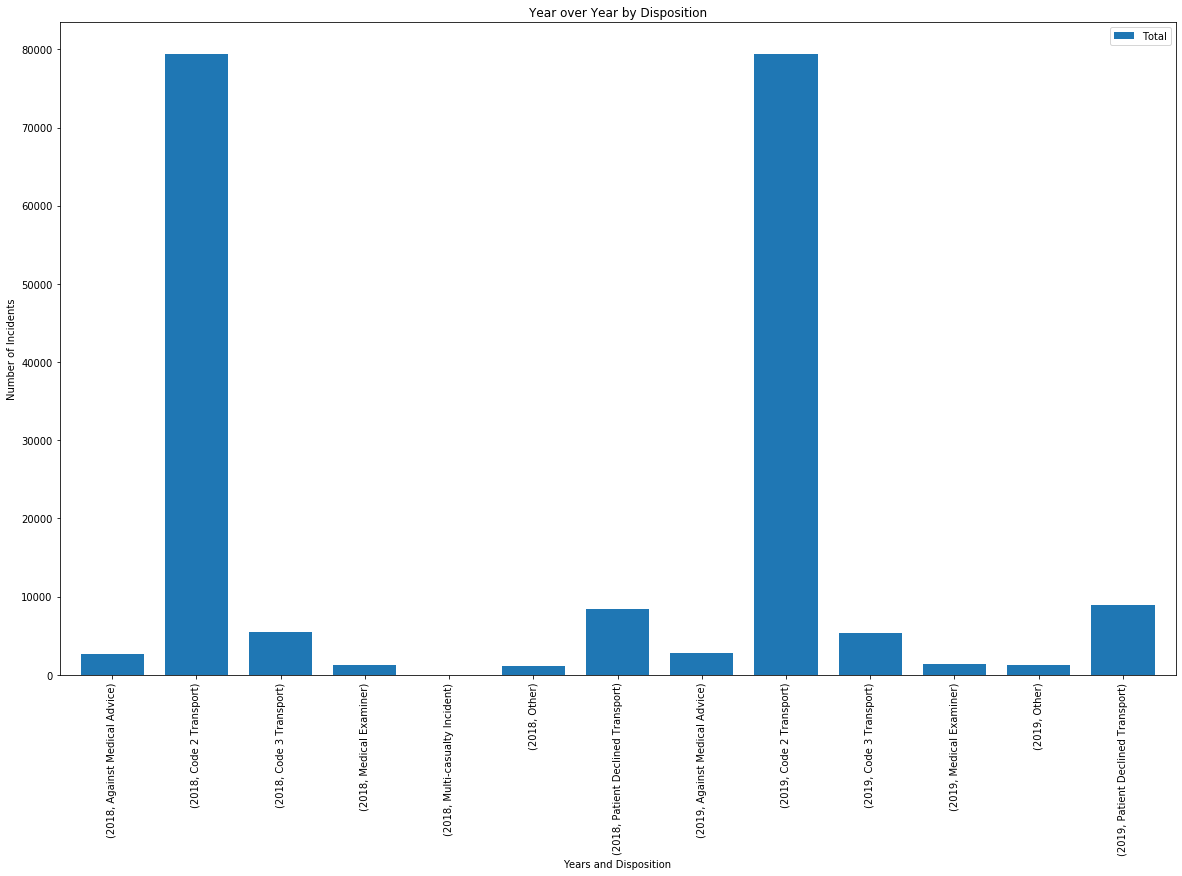

In [27]:
# TRANSPORT BY TYPE BY YEAR
df_disposition.plot(kind='bar', figsize = (20,12), width = 0.75)

plt.xlabel("Years and Disposition")
plt.ylabel("Number of Incidents")
plt.title("Year over Year by Disposition")

plt.show()

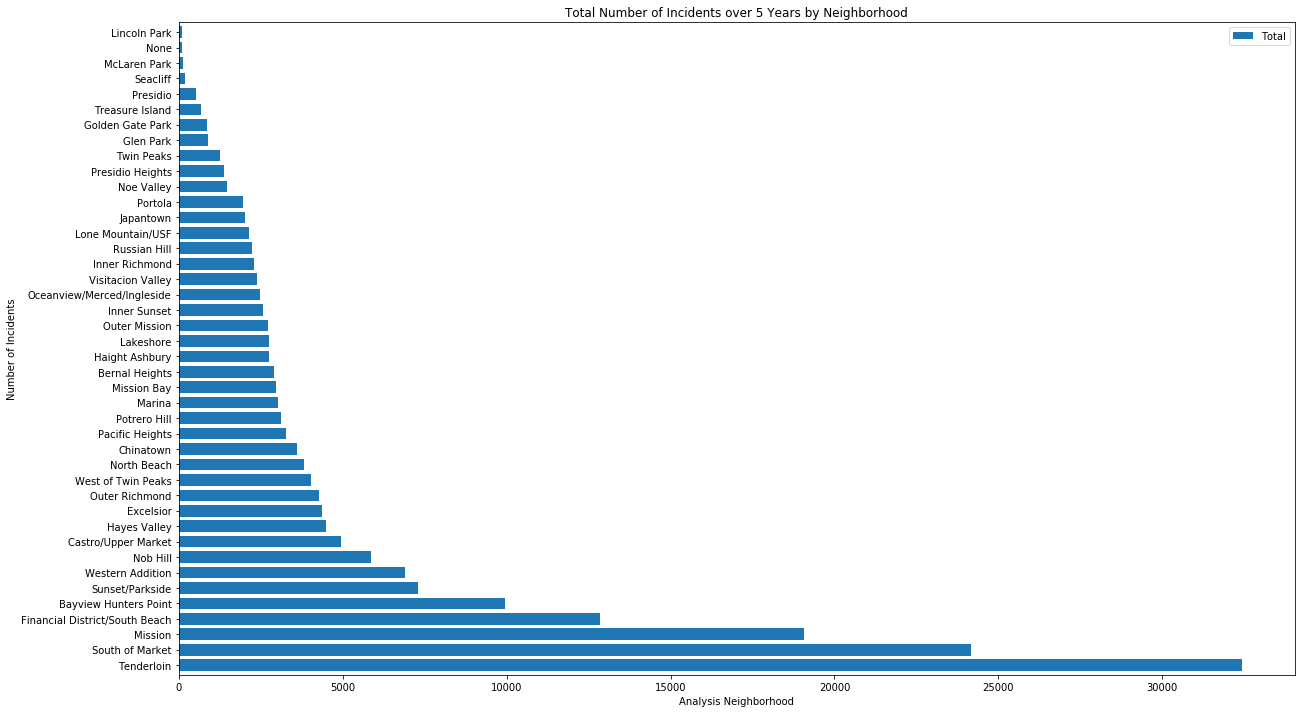

In [28]:
df_nborcount.plot.barh(x = 'Neighborhood', y = 'Total', width = .75, figsize = (20, 12))

plt.xlabel("Analysis Neighborhood")
plt.ylabel("Number of Incidents")
plt.title("Total Number of Incidents over 5 Years by Neighborhood")

plt.show()

From this map there does seem to be an indication that the location of the facilities have a corrilation to the time it takes to trasport.  

###  Statistical and Machine Learning Analysis with KNearest Neighbor and DB-SCAN
The last dimension of this analysis is to cluster the calls and visualize that against where the facilities are located.  To accomplish this the first step is to determine the best epsilon value for the DBSCAN machine learning process.  One way to do this is use a nearest neighbor graph and where the sharpest curve is can help identify the best location for the epsilon. 

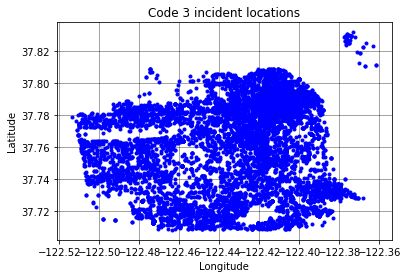

In [29]:
plt.plot(df_code3['Longitude'], df_code3['Latitude'], marker='.', linewidth=0, color='blue' )
plt.grid(which = 'major', color ='black', alpha=0.45)
plt.title("Code 3 incident locations")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [30]:
# NORMALIZING THE DATA SETS FOR DBSCAN & TRANSFORMING EACH SET

# Other data set
dbscan_other = df_other[['Latitude' , 'Longitude']] # set the points
dbscan_other = np.nan_to_num(dbscan_other) # convert to an np array
dbscan_other = StandardScaler().fit_transform(dbscan_other) # Normalize the data

# Non-priority data set

dbscan_code2 = df_code2[['Latitude' , 'Longitude']] # set the points
dbscan_code2 = np.nan_to_num(dbscan_code2) # convert to an np array
dbscan_code2 = StandardScaler().fit_transform(dbscan_code2) # Normalize the data

# Priority data set
dbscan_code3 = df_code3[['Latitude' , 'Longitude']] # set the points
dbscan_code3 = np.nan_to_num(dbscan_code3) # convert to an np array
dbscan_code3 = StandardScaler().fit_transform(dbscan_code3) # Normalize the data
    

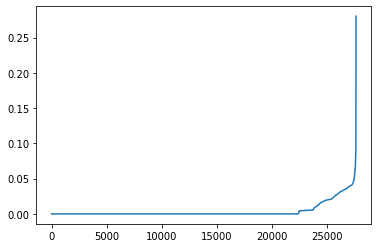

In [31]:
# EPSILON FOR OTHER DATA
#  Find the best fit epsilon using nearest neighbors
X = dbscan_other
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis = 0)
distances = distances[:,1]
plt.plot(distances)

It appears from this chart that the sharpest bend for the Other category is right at 0.03.  So the epsilon value for the other data for the machine learning DBSCAN will be set at this level.

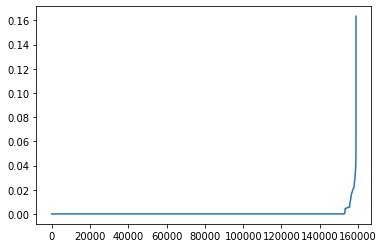

In [32]:
#  EPSILON FOR CODE 2 DATA
#  Find the best fit epsilon using nearest neighbors
X = dbscan_code2
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis = 0)
distances = distances[:,1]
plt.plot(distances)

Again this appears the epsilon needs to be much lower than some others.  While this is difficult to read it appears the sharpest curve is at 0.01.

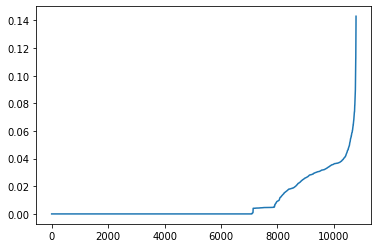

In [33]:
#  Find the best fit epsilon using nearest neighbors
X = dbscan_code3
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis = 0)
distances = distances[:,1]
plt.plot(distances)

In this case, there are two sharp curves.  The fist at somewhere around 0.005 and the second around 0.035.  For the purposes of this set the epislon will be set at 0.035.  

In [34]:
#DBSCAN MODEL FOR THE CODE OTHER DATA
db_other = DBSCAN(eps = 0.1, min_samples = 60).fit(dbscan_other)
labels = db_other.labels_
df_other['Clust_db'] = labels
realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

# Separating the outliers from clusted data
other_outliers = df_other[db_other.labels_ == -1]
other_clusters = df_other[db_other.labels_ != -1]

# Setting the colors
colors_other = db_other.labels_
colors_clusters_other = colors_other[colors_other != -1]
color_outliers_other = 'black'

#  Model information
from collections import Counter
clusters = Counter(db_other.labels_)
print("Number of clusters for other data = {}".format(len(clusters)-1))


Number of clusters for other data = 22


C:\Users\suenc\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [35]:
#DBSCAN MODEL FOR THE CODE 2 DATA
db_code2= DBSCAN(eps = 0.03, min_samples = 50).fit(dbscan_code2)
labels = db_code2.labels_
df_code2['Clust_db'] = labels
realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

# Separating the outliers from clusted data
code2_outliers = df_code2[db_code2.labels_ == -1]
code2_clusters = df_code2[db_code2.labels_ != -1]

# Setting the colors
colors_code2 = db_code2.labels_
colors_clusters_code2 = colors_code2[colors_code2 != -1]
color_outliers_code2 = 'black'

#  Model information
from collections import Counter
clusters = Counter(db_code2.labels_)
print("Number of clusters for code 2 data = {}".format(len(clusters)-1))


Number of clusters for code 2 data = 370


C:\Users\suenc\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [36]:
#DBSCAN MODEL FOR THE CODE 3 DATA
db_code3 = DBSCAN(eps = 0.05, min_samples = 20).fit(dbscan_code3)
labels = db_code3.labels_
df_code3['Clust_db'] = labels
realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

# Separating the outliers from clusted data
code3_outliers = df_code3[db_code3.labels_ == -1]
code3_clusters = df_code3[db_code3.labels_ != -1]

# Setting the colors
colors = db_code3.labels_
colors_clusters = colors[colors != -1]
color_outliers = 'black'

#  Model information
from collections import Counter
clusters = Counter(db_code3.labels_)
print("Number of clusters = {}".format(len(clusters)-1))


Number of clusters = 59


C:\Users\suenc\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Results
This data evaluation is again an introductory use of data science techniques for emergency services.  The primary focus was on how the emergency medical service (EMS) is best able to cope with the demands of the customers and patients.  The data evaluated shows a few areas of potential concern for those customers based on the ability of the EMS provider, the San Francisco Fire Department, to transport patients in a timely manner.

While there are certainly more dimensions that should be evaluated than the two primary dimensions evaluated here, location of receiving facilities and call volume, it appears that there are some areas of possible improvement for the service.  

### Call Density
The first parameter to evaluate is the call density.  The San Francisco system is very busy, primarily in the city centers.  The lowest call volumes are in the park areas and on Treasure Island.  The highest density is in the old quarter (Tenderloin neighborhood), downtown areas, the south east Bayview neighborhood, and the western Sunset/Parkside neighborhoods.  It is interesting to note that there are few resources on the west side and south side of the city, while both of these areas do have a significant number of incidents.

The following map shows a overall call volume by analysis neighborhood.  All facilities where patients can be transported are identified as a blue dot.  

In [37]:
sanfran_map_density

### Transport Time as a Analysis Parameter
In emergency services one of the primary functional analysis for performance is time, "How long does a certain action take" or "how long does it take to respond" and so on.  It is outside of the scope of this analysis to go too deep into the reasons for this need, however it is an important consideration when looking at medical facilities and whether they may be placed in the correct location.

The facilities are be broken into two sets.  The first set is the emergency room/hospital set and the second set will include urgent care, doctor facilities, and other medical facilities.  The reasoning for this is the assumption that an emergency room/hospital will be able to provide a higher level of emergency care than the other care facilities.

The transport time variable be evaluated in two categories.  Code 2 (non-priority) transports and code 3 (priority) transports.  The assumption is that the more acute or sever cases will be transported priority and should also be transported to an emergency room or hospital.  The non-priority transports can potentially be transported to any facility.  It bears repeating here that it is unknown from the data whether the city of San Francisco allows transports to other facilities, but for the sake of this evaluation the assumption is that they do allow this type of transport.  The final group, the patients that were not transported will make up a different evaluation at the end of this analysis.

##### Code 3 Transport Averages with Emergency Facilities
The following map shows transport time of priority transports and includes all 5 years of the data.  As noted above this is the primary mode of transport within the San Francisco fire service.  Also as noted in the data prep area the excessive or missing transport times have been removed.  The longest transport times (red on the following charts) are between 14 and 16 minutes (848-952 seconds) on average and these areas are in the northeast and southeast analysis districts.  

In [38]:
sanfran_map_time

The following chart is the results of the DBSCAN clustering analysis.  The red dots indicate emergency room and hospital locations.  While many of the clusters are around the facilities, there are several areas that appear to be underserved.  Most notably in the south and north east.

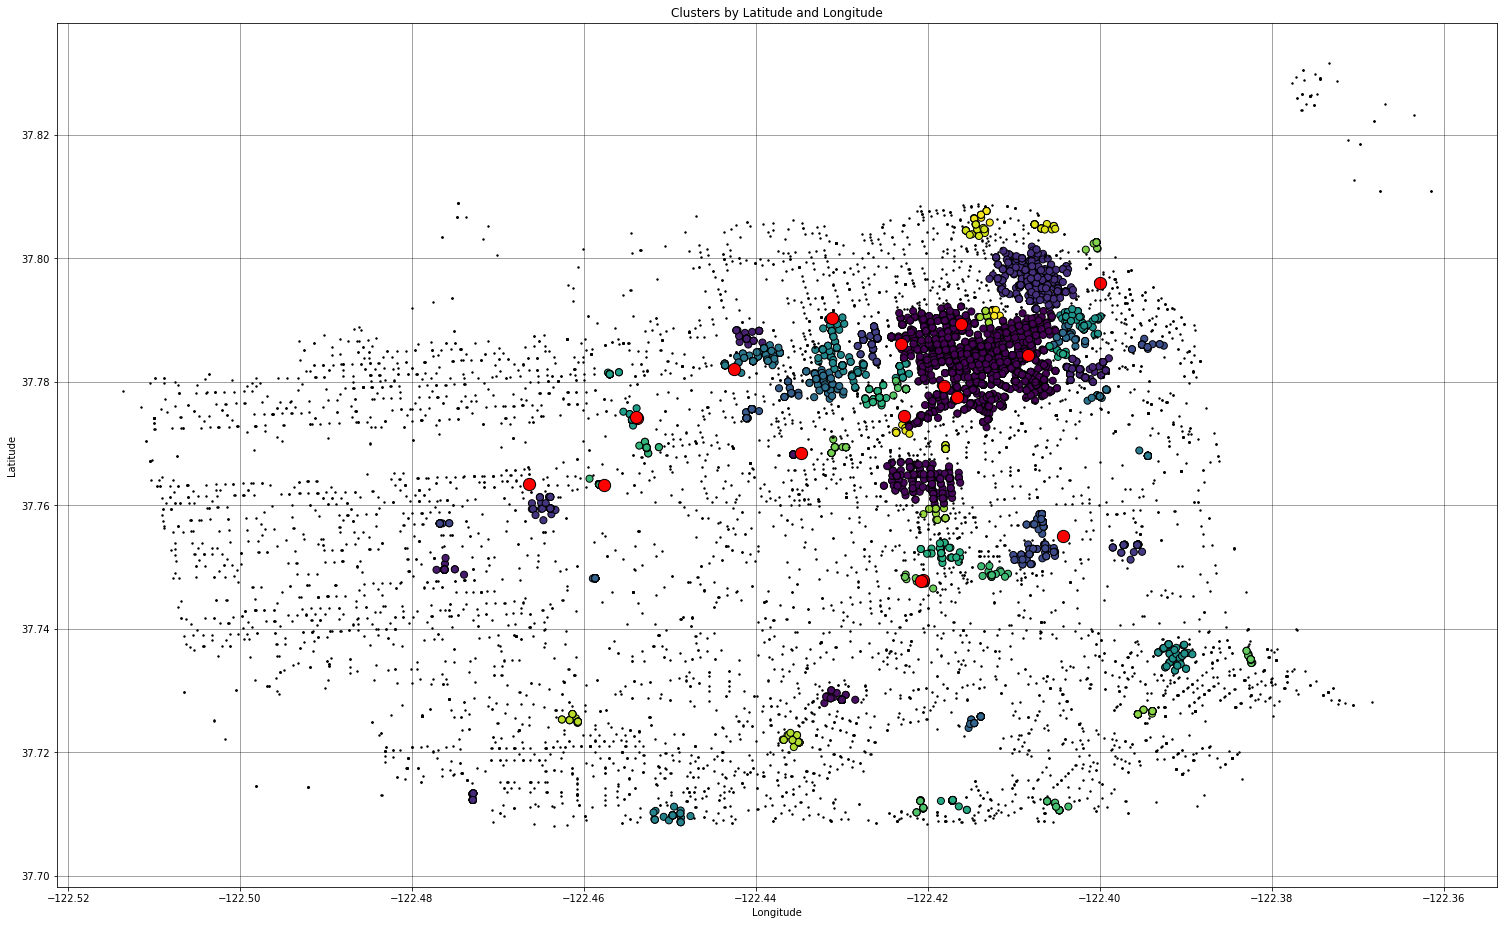

In [39]:
# PLOTTING THE CODE 3 MODEL

code3_fig = plt.figure(figsize = (20,12))

ax = code3_fig.add_axes([.1, .1, 1, 1])

ax.scatter(code3_clusters['Longitude'], code3_clusters['Latitude'], c = colors_clusters, edgecolors = 'black', 
           s = 50)
ax.scatter(code3_outliers['Longitude'], code3_outliers['Latitude'], c = color_outliers, edgecolors = 'black', 
           s = 2)
ax.scatter(df_er['lng'], df_er['lat'], c = 'red', edgecolors ='black', s = 150)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.title('Clusters by Latitude and Longitude')

plt.grid(which = 'major', color = 'black', alpha = 0.45)

plt.show()

##### Code 2 Transport Average Time with All Facilities
The following map shows transport time of non-priority transports.  As noted above this is the primary mode of transport within the San Francisco fire service.  Also as noted in the data prep area the excessive or missing transport times have been removed.  The red dots are the emergency facilities while the blue dots are the urgent care facilities.  The longest transport times (red on the following charts) are between 20 and 26 minutes (1234-1574 seconds) on average and these areas are in the northeast and south analysis districts.  

In [40]:
sanfran_map_time2

The following chart is the results of the DBSCAN clustering analysis for these non-priority calls.  Again, the same phenomenon presents itself with clusters in the south and north east not near facilities, with an additional set of clusters in the west of the city that also have no apparent facilities.

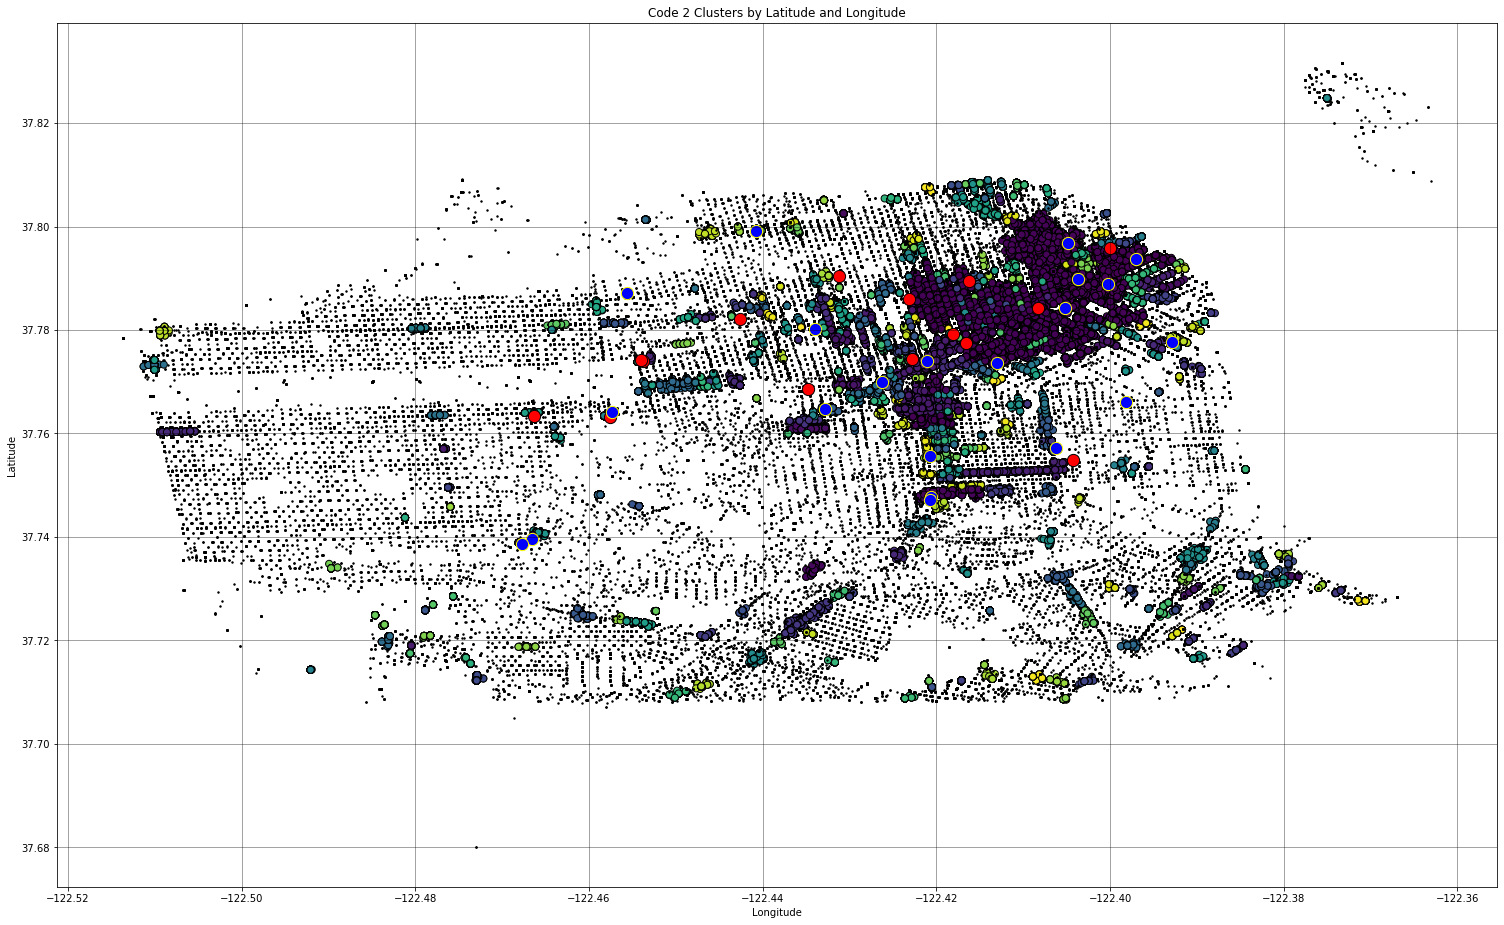

In [41]:
# PLOTTING THE CODE 2 MODEL
code2_fig = plt.figure(figsize = (20,12))

ax = code2_fig.add_axes([.1, .1, 1, 1])

ax.scatter(code2_clusters['Longitude'], code2_clusters['Latitude'], c = colors_clusters_code2, edgecolors = 'black', 
           s = 50)
ax.scatter(code2_outliers['Longitude'], code2_outliers['Latitude'], c = color_outliers_code2, edgecolors = 'black', 
           s = 2)
ax.scatter(df_er['lng'], df_er['lat'], c = 'red', edgecolors ='black', s = 150)
ax.scatter(df_uc['lng'], df_uc['lat'], c = 'blue', edgecolors ='yellow', s = 150)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.title('Code 2 Clusters by Latitude and Longitude')

plt.grid(which = 'major', color = 'black', alpha = 0.45)

plt.show()

#### Non-Transport Incidents
One final DBSCAN model was created using the incidents that did not transport.  Since the transport time cannot be evaluated the location and clustering of these incidents show similar underserved areas as the non-priority transports.  These remain the south, north east, and western portions of the city.

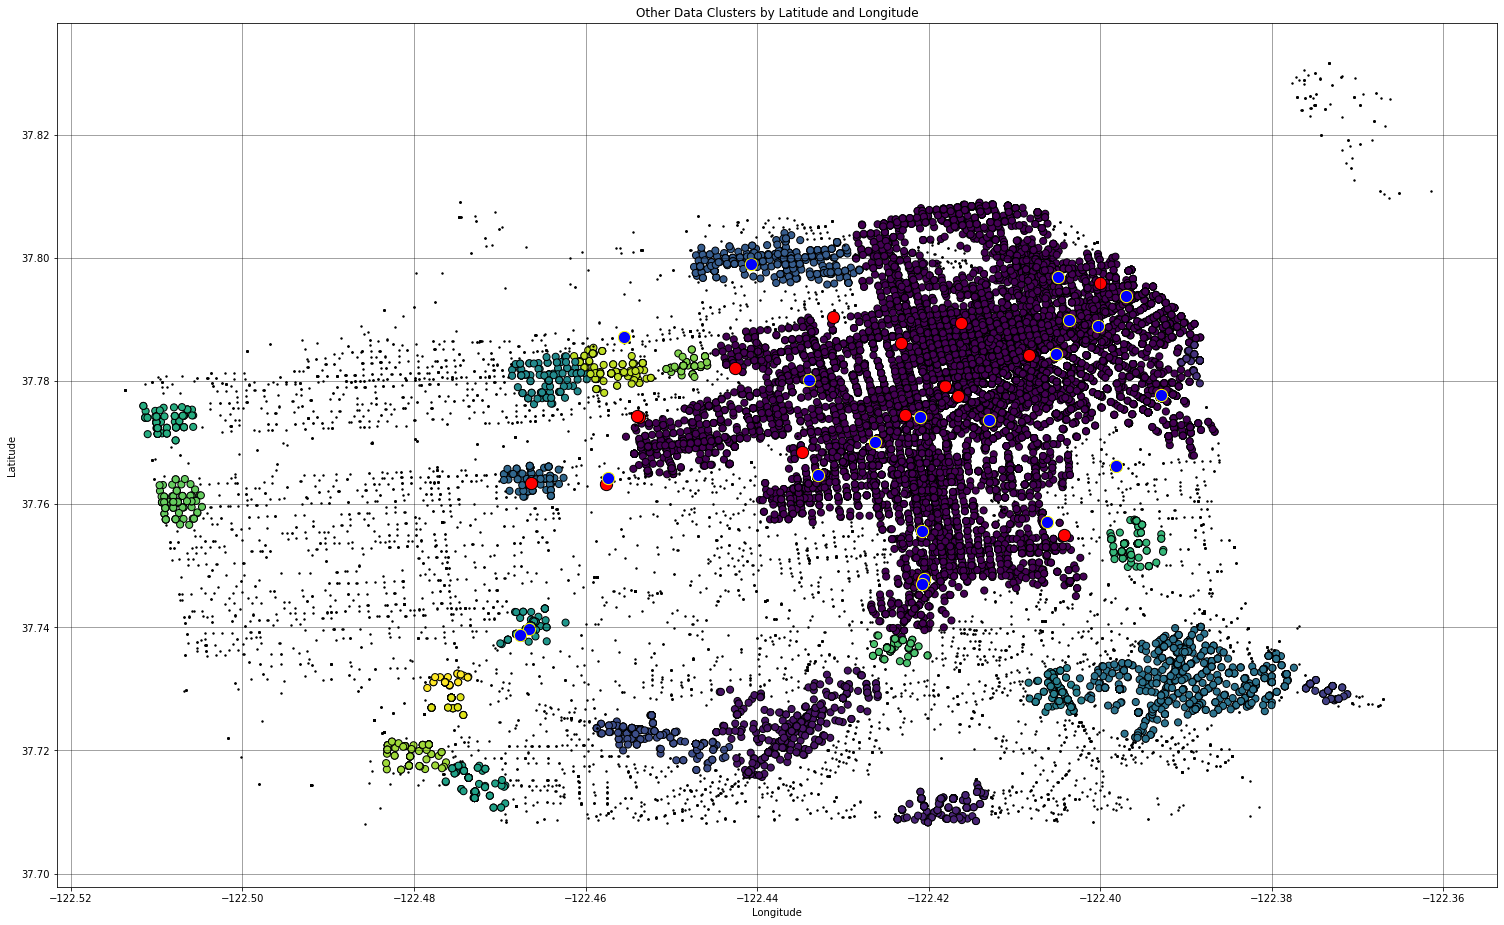

In [42]:
# PLOTTING THE OTHER MODEL
other_fig = plt.figure(figsize = (20,12))

ax = other_fig.add_axes([.1, .1, 1, 1])

ax.scatter(other_clusters['Longitude'], other_clusters['Latitude'], c = colors_clusters_other, edgecolors = 'black', 
           s = 50)
ax.scatter(other_outliers['Longitude'], other_outliers['Latitude'], c = color_outliers_other, edgecolors = 'black', 
           s = 2)
ax.scatter(df_er['lng'], df_er['lat'], c = 'red', edgecolors ='black', s = 150)
ax.scatter(df_uc['lng'], df_uc['lat'], c = 'blue', edgecolors ='yellow', s = 150)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.title('Other Data Clusters by Latitude and Longitude')

plt.grid(which = 'major', color = 'black', alpha = 0.45)

plt.show()

## Discussion
It is difficult to make any firm conclusions based on so few parameters, however it does appear that extended transport times may have a correlation to the location of the receiving facilities. It is clear the western and southern analysis districts have no facilities close, significant clustering and call volumes, and have more extended transport times. Some of the park areas have extended transport averages but have very few data points and no clustering. It seems likely that one area of performance enhancement may be the evaluation of locations more to the south and west of the current centers. However, as noted earlier, facilities in other cities may be available for transport, so the southern analysis districts may indeed have facilities close in neighboring communities, that would not show up with this evaluation.

An anomaly is the north eastern neighborhood, the North Beach area, that does have a facility close but has extended transport times. This might be indicative of a lack of capacity of nearby facilities to handle call volume which would require ambulances to transport to other, further, locations. It also might be due to access into the area or any number of other issues. However, that analysis is outside the scope of this article.

An additional consideration when looking at this data and this analysis is the data itself. There is high confidence in the information about the incidents, the incident geography, the shape of the districts, and other data from the San Francisco open data portal. The Foursquare data is likely to be complete, however there may be some missing facilities but the data was not audited against any official city information.

One additional talking point is the assumptions that were made. While all of them appear reasonable, they are by no means definitive. For instance where the service can transport, what the community expectation for transport time to the hospital is, and many other variables may not have been addressed here, and this was intentional. 

## Conclusion
The reader should keep in mind that this analysis was intended as an introductory study of utilizing current data science tools to evaluate emergency services, specifically the emergency medical services, and their ability to provide timely and effective transports to their clients. While it may appear from this presentation that there are some areas of improvement available to San Francisco, and it appears that it may be due to the position and type of receiving facilities for patients, this is not a recommendation nor an accusation of any service shortages. In short this is not a conclusive suggestion, rather a different view of the information and a purely academic application of publicly accessible data. 